In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas_datareader.data as pdr
from cytoolz import sliding_window
import pickle
from itertools import groupby
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
from scipy.stats import t

#from IPython import display
from IPython.core.display import display, HTML
import pandas_market_calendars as mcal


C:\Users\User\AppData\Local\Temp\ipykernel_23072\2277229180.py:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
def test_increasing_value(v):
    if(v>0):
        return 1
    else:
        return 0

def test_decreasing_value(v):
    if(v<0):
        return 1
    else:
        return 0

def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

In [3]:
dict_sectors = {'Basic Materials':'VAW', 'Communication Services':'VOX', 'Consumer Cyclical':'VCR',
       'Consumer Defensive':'VDC', 'Energy':'VDE', 'Financial Services':'VFH', 'Healthcare':'VHT',
       'Industrials':'VIS', 'Real Estate':'VNQ', 'Technology':'VGT', 'Utilities':'VPU', 'error':'error'}

dict_indexes = {'SPTM':'SP1500', 'SPY':'SP500', 'SLY':'SP600', 'MDYG':'SP400','DIA':'DOW','error':'error'}

dict_sectors_reverse = {'VAW':'Basic Materials',
 'VOX':'Communication Services',
 'VCR':'Consumer Cyclical',
 'VDC':'Consumer Defensive',
 'VDE':'Energy',
 'VFH':'Financial Services',
 'VHT':'Healthcare',
 'VIS':'Industrials',
 'VNQ':'Real Estate',
 'VGT':'Technology',
 'VPU':'Utilities',
 'error': 'error'}

indexes = ['SPTM', 'SPY', 'SLY', 'MDYG', 'DIA']
sectors = ['VOX', 'VCR', 'VDC', 'VDE', 'VFH', 'VHT', 'VIS', 'VGT', 'VAW',
       'VNQ', 'VPU']

In [4]:
#SPDR Sector ETF
spdr_sector_symbols = ['XLK','XLV','XLY','XLC','XLF','XLI','XLP','XLU','XLB','XLRE','XLE']

spdr_sector_names = ['Information Technology','Health Care','Consumer Discretionary','Communication Services','Financials','Industrials','Consumer Staples','Utilities','Materials','Real Estate','Energy']

dict_spdr_sectors = dict(zip(*[spdr_sector_symbols,spdr_sector_names]))

In [5]:
today = datetime.today().strftime('%Y-%m-%d')
#today = end

past = (datetime.strptime(today, '%Y-%m-%d') - relativedelta(months=64*4)).strftime('%Y-%m-%d')
#past = start
start = past
end = today

nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=past, end_date=today)

In [6]:
def getStock(npa):
    symbol = npa[0]
    start_=npa[1]
    end_=npa[2]
    
    data_ = yf.download(symbol, start=start_,end=end_)
  
    return([symbol,data_])

In [7]:
#yf.download(sectors).dropna()

In [8]:

prices_df = pd.DataFrame()
for f in [*indexes,*sectors]:
    temp = getStock([f,start,end])
    temp_df = temp[1]
    temp_df['Symbol'] = temp[0]
    prices_df = pd.concat([prices_df,temp_df],axis=0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [9]:
def highlight_cells(val,threshold):
    color = 'yellow' if val < threshold else ''
    return 'background-color: {}'.format(color)

In [10]:
si = ['03-31','06-30','09-30','12-31']
               
#[start,end, prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, sectors, indexes, screener_sorted] = pickle.load(open('./data_object.pkl', 'rb'))

#prices = prices_df
#prices = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="SP1500_Sectors_Indexes_Prices")

In [11]:
indexes_df = pd.DataFrame()

for s in indexes:
    indexes_df = pd.concat([prices_df[prices_df['Symbol'] == s][['Adj Close']],indexes_df],axis=1)
    
indexes_df.columns = indexes
                     
indexes_df_qtr_pvt = indexes_df.asfreq('d').interpolate().resample('4W-'+nyse_dates.index[-1].strftime('%a')).mean()

sectors_df = pd.DataFrame()

for s in sectors:
    sectors_df = pd.concat([prices_df[prices_df['Symbol'] == s][['Adj Close']],sectors_df],axis=1)
    
sectors_df.columns = sectors

sectors_df_qtr_pvt = sectors_df.asfreq('d').interpolate().resample('4W-'+nyse_dates.index[-1].strftime('%a')).mean()

combined_indexes_sectors_df = pd.concat([indexes_df_qtr_pvt,sectors_df_qtr_pvt],axis=1)
combined_indexes_sectors_return_pvt_df = combined_indexes_sectors_df.pct_change().dropna()

In [12]:
"""
cli_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CLI.../OECD?contentType=csv&detail=USA&separator=comma&csv-lang=en")
#cli_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CLI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")
bci_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.BCI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")
cci_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CCI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")

print(np.unique(cci_df.LOCATION))

bci_df_USA = bci_df[bci_df['LOCATION']=='USA']
bci_df_USA.index = bci_df_USA[bci_df_USA['LOCATION']=='USA'].set_index('TIME').index.map(lambda t: datetime.strptime(t,'%Y-%m'))
cci_df_USA = cci_df[cci_df['LOCATION']=='USA']
cci_df_USA.index = cci_df_USA[cci_df_USA['LOCATION']=='USA'].set_index('TIME').index.map(lambda t: datetime.strptime(t,'%Y-%m'))
cli_df_USA = cli_df[cli_df['LOCATION']=='USA']
cli_df_USA.index = cli_df_USA[cli_df_USA['LOCATION']=='USA'].set_index('TIME').index.map(lambda t: datetime.strptime(t,'%Y-%m'))
"""

'\ncli_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CLI.../OECD?contentType=csv&detail=USA&separator=comma&csv-lang=en")\n#cli_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CLI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")\nbci_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.BCI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")\ncci_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CCI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")\n\nprint(np.unique(cci_df.LOCATION))\n\nbci_df_USA = bci_df[bci_df[\'LOCATION\']==\'USA\']\nbci_df_USA.index = bci_df_USA[bci_df_USA[\'LOCATION\']==\'USA\'].set_index(\'TIME\').index.map(lambda t: datetime.strptime(t,\'%Y-%m\'))\ncci_df_USA = cci_df[cci_df[\'LOCATION\']==\'USA\']\ncci_df_USA.index = cci_df_USA[cci_df_USA[\'LOCATION\']==\'USA\'].set_index(\'TIME\').index.map(lambda t: datetime.strptime(t,\'%Y-%m\'))\ncli_df_USA = cli_d

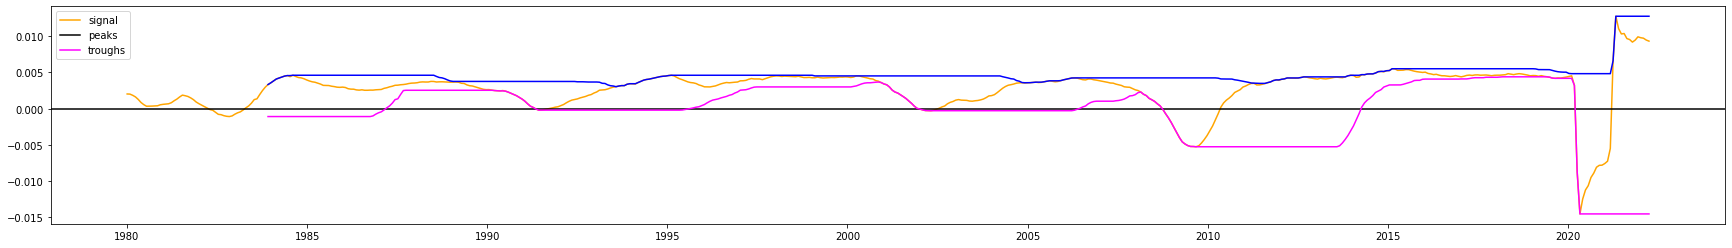

In [13]:
#Leading Indicators OECD: Leading indicators: CLI: Normalised for the United States
USALOLITONOSTSAM = pdr.DataReader('USALOLITONOSTSAM','fred','1955-01-01',end)-100

#Coincident Economic Activity Index for the United States
USPHCI = pdr.DataReader('USPHCI','fred','1955-01-01',end)
#USPHCI_signal = USPHCI.rolling(4).mean()-USPHCI.rolling(12*4).mean()

#Gross Domestic Product 
GDP = pdr.DataReader('GDP','fred','1955-01-01',end)

#Real personal income excluding current transfer receipts
W875RX1 = pdr.DataReader('W875RX1','fred','1955-01-01',end)
"""
signal = USALOLITONOSTSAM['USALOLITONOSTSAM']

Recovery = (signal<0)*(signal.pct_change(1)>0)
Expansion = (signal>0)*(signal.pct_change(1)>0)
Slowdown = (signal>0)*(signal.pct_change(1)<0)
Recession = (signal<0)*(signal.pct_change(1)<0)
"""
#combined_leading = pd.concat([cli_df_USA['Value']-100,USALOLITONOSTSAM],axis=1)
#combined_leading = pd.concat([cli_df_USA['Value'],USALOLITONOSTSAM+100],axis=1)
#proposed_signal_pre = pd.concat([USPHCI,GDP,W875RX1],axis=1)
#proposed_signal_pre = pd.concat([USPHCI,W875RX1],axis=1)
proposed_signal_pre = pd.concat([USPHCI],axis=1)
data_pre_scaled = proposed_signal_pre.interpolate(limit_area='inside').dropna()

#signal = combined_leading.mean(axis=1)
#signal = combined_leading.mean(axis=1).asfreq('d').interpolate().asfreq('4W-'+nyse_dates.index[-1].strftime('%a'))
#signal = combined_leading.mean(axis=1).asfreq('d').interpolate().resample('4W-'+nyse_dates.index[-1].strftime('%a')).mean()

scaler = StandardScaler()

scaler.fit(data_pre_scaled)
#data_scaled = pd.DataFrame(scaler.fit_transform(data_pre_scaled),index=data_pre_scaled.index)
#data_scaled.plot()

#QTR_SMA = cli_df_USA['Value'].rolling(3).mean()

fig, ax1 = plt.subplots( figsize=(30,4) )

#plt.plot(signal1)

#ax2 = ax1.twinx()

data_pre_t_scaled = ((data_pre_scaled-data_pre_scaled.mean())/(data_pre_scaled.std()*np.sqrt(len(data_pre_scaled)))).mean(axis=1)
proposed_signal = pd.DataFrame(t.cdf(data_pre_t_scaled,df=len(data_pre_t_scaled)),index=data_pre_t_scaled.index)

signal = proposed_signal.asfreq('D').interpolate().resample('4W-'+nyse_dates.index[-1].strftime('%a')).mean().pct_change(13)

ST_SMA = signal.rolling(13).mean()
LT_SMA = signal.rolling(13*4).mean()
#signal = ST_SMA - LT_SMA
signal_ = ST_SMA-LT_SMA

ax1.plot(signal, color='orange')

ax1.axhline(y = 0, color = 'black', linestyle = '-')

#troughs
troughs = signal.rolling(13*4).min()
ax1.plot(troughs,color='magenta')
#troughs = trough

#peaks
peaks = signal.rolling(13*4).max()
ax1.plot(peaks, color='blue')
#ax1.legend(['signal','SMA_signal','peaks','troughs'])
ax1.legend(['signal','peaks','troughs'])
#peaks = peak

#plt.plot(combined_leading)
#plt.plot(signal_MACD)
#plt.show()

In [14]:
#cli_range_df = cli_df_USA[(cli_df_USA.index<=today) & (cli_df_USA.index>=past)]

In [15]:
#plt.plot(USPHCI.pct_change())

In [16]:
"""
slowdown = (business_cycle['ST_SMA']<business_cycle['ST_SMA'].shift(1))& (expansion==False) & (recovery==False) & (business_cycle['signal']<business_cycle['peak'])# & (business_cycle['signal']!=business_cycle['troughs'])#
np.sum(slowdown)
"""

"\nslowdown = (business_cycle['ST_SMA']<business_cycle['ST_SMA'].shift(1))& (expansion==False) & (recovery==False) & (business_cycle['signal']<business_cycle['peak'])# & (business_cycle['signal']!=business_cycle['troughs'])#\nnp.sum(slowdown)\n"

In [17]:
business_cycle = pd.concat([signal,troughs,peaks,ST_SMA,LT_SMA],axis=1)
business_cycle.columns = ["signal","troughs","peaks","ST_SMA","LT_SMA"]

if(True):
    #expansion = (business_cycle['ST_SMA']>business_cycle['LT_SMA'])&(business_cycle['ST_SMA']>0)
    
    slowdown = (business_cycle['signal']<business_cycle['signal'].shift(1))&(business_cycle['signal']>0)
    
    expansion = (business_cycle['signal']>business_cycle['signal'].shift(1))&(business_cycle['signal']>0)
    
    #useful for extending slowdown's
    if(False):
        #for i in range(0,100,1):
        condition = True
        while condition:
            expansion_pre = (business_cycle['signal']>business_cycle['signal'].shift(1))&(business_cycle['signal']>0)
            expansion = expansion_pre & (slowdown.shift(1)==False)
            slowdown_new = expansion_pre&(expansion==False)&(slowdown==False)
            slowdown[slowdown_new.values]=True

            if(len(slowdown[slowdown_new.values])==0):
                condition=False
            else:
                condition=True

    #expansion = (business_cycle['signal']==business_cycle['peaks'])&(business_cycle['signal']>0)
    
    #expansion = (business_cycle['ST_SMA'].pct_change()>0)&(business_cycle['signal']>0)
    
    recovery = (business_cycle['signal']>business_cycle['signal'].shift(1))&(business_cycle['signal']<0)
    #recovery = (business_cycle['ST_SMA'].pct_change()>0)&(business_cycle['signal']<0)
    
    #recession = (business_cycle['ST_SMA']>business_cycle['LT_SMA'])&(business_cycle['ST_SMA']<0)
    recession = (business_cycle['signal']<business_cycle['signal'].shift(1))&(business_cycle['signal']<0)
    #recession = (business_cycle['ST_SMA'].pct_change()<0)&(business_cycle['signal']<0)
    
    #slowdown = (business_cycle['signal']<business_cycle['signal'].shift(1))&(business_cycle['signal']>0)
    #slowdown = (business_cycle['signal']<business_cycle['peaks'])&(business_cycle['signal']>0)
    #slowdown = (business_cycle['ST_SMA'].pct_change()<0)&(business_cycle['signal']>0)

if(False):
    expansion = (business_cycle['ST_SMA']>business_cycle['LT_SMA']) #& (business_cycle['signal']==business_cycle['peak'])
    #recovery = (business_cycle['ST_SMA']>business_cycle['ST_SMA'].shift(1)) & (business_cycle['signal']>business_cycle['troughs']) & (business_cycle['ST_SMA']<business_cycle['LT_SMA']) #& (business_cycle['ST_SMA']<business_cycle['LT_SMA'])
    recovery = (expansion==False) & (business_cycle['signal']>business_cycle['troughs'])
    expansion = (expansion) & (recovery==False) 
    #expansion = (business_cycle['ST_SMA']>business_cycle['LT_SMA'])
    #slowdown = (combined['ST_SMA']>combined['LT_SMA']) & (combined['signal']<combined['peak'])

    #slowdown = (business_cycle['ST_SMA']<business_cycle['ST_SMA'].shift(1)) & (expansion==False) & (recovery==False) & (business_cycle['signal']<business_cycle['peak']) & (business_cycle['signal']!=business_cycle['troughs'])
    slowdown = (business_cycle['ST_SMA']<business_cycle['ST_SMA'].shift(1))& (expansion==False) & (recovery==False) & (business_cycle['signal']<business_cycle['peak'])# & (business_cycle['signal']!=business_cycle['troughs'])#
    np.sum(slowdown)
    #recession = (combined['ST_SMA']<combined['LT_SMA']) & (combined['signal']==combined['troughs'])
    #if yesterday's difference less than today's difference
    #recession = (business_cycle['ST_SMA']<business_cycle['LT_SMA']) & (business_cycle['signal']==business_cycle['troughs']) & (business_cycle['signal']<business_cycle['signal'].shift(1)) & (abs(business_cycle['signal'].pct_change())>abs(business_cycle['signal'].pct_change().shift(1)))

    #recession = ((business_cycle['peak']-business_cycle['troughs'])>(business_cycle['peak']-business_cycle['troughs']).shift(1)) & (business_cycle['signal'] < business_cycle['signal'].shift(1)) & (abs(business_cycle['signal'].diff())>(abs(business_cycle['signal'].shift(1).diff()))**2) & (business_cycle['signal']<business_cycle['ST_SMA']) & (((business_cycle['signal']<business_cycle['ST_SMA']) & ((business_cycle['ST_SMA']-business_cycle['signal'])>(((business_cycle['ST_SMA']-business_cycle['signal']).shift(1))))))
    recession = ((business_cycle['signal']==business_cycle['troughs'])&((business_cycle['ST_SMA']-business_cycle['signal'])/(business_cycle['peak']-business_cycle['signal'])>.25)) #\
    """
    &\
    ((business_cycle['signal'].pct_change()/business_cycle['signal'].pct_change().shift(1))>1.5)
    """
    """
    &\
    ((business_cycle['LT_SMA']-business_cycle['ST_SMA'])>(business_cycle['LT_SMA']-business_cycle['ST_SMA']).shift(1))\
    &((business_cycle['ST_SMA']-business_cycle['signal'])>(business_cycle['ST_SMA']-business_cycle['signal']).shift(1))\
    &((business_cycle['peak']-business_cycle['LT_SMA'])>(business_cycle['peak']-business_cycle['LT_SMA']).shift(1))\
    &((business_cycle['peak']-business_cycle['troughs'])>(business_cycle['peak']-business_cycle['troughs']).shift(1))\
    """
    #&(business_cycle['signal'].pct_change()<-.25)

    #& ((business_cycle['peak']-business_cycle['troughs'])>(business_cycle['peak']-business_cycle['troughs']).shift(1)) & (business_cycle['signal'] < business_cycle['signal'].shift(1)) & (abs(business_cycle['signal'].diff())>(abs(business_cycle['signal'].shift(1).diff()))**2) & (business_cycle['signal']<business_cycle['ST_SMA']) & (((business_cycle['signal']<business_cycle['ST_SMA']) & ((business_cycle['ST_SMA']-business_cycle['signal'])>(((business_cycle['ST_SMA']-business_cycle['signal']).shift(1))))))

    #recession = (business_cycle['troughs']<business_cycle['troughs'].shift(1))&(abs(business_cycle['troughs'].pct_change())>abs(business_cycle['troughs'].pct_change()).shift(1))
    #((business_cycle['signal']<business_cycle['ST_SMA'])&(abs(business_cycle['signal']<business_cycle['ST_SMA']))>(abs(business_cycle['LT_SMA']-business_cycle['ST_SMA'])))

    #recession = (business_cycle['ST_SMA']<business_cycle['LT_SMA']) & (business_cycle['signal']<business_cycle['signal'].shift(1)) & (abs(business_cycle['signal'].pct_change())>abs(2*business_cycle['signal'].pct_change().shift(1))) & (business_cycle['ST_SMA']<business_cycle['ST_SMA'].shift(1)) & (abs(business_cycle['ST_SMA'].pct_change())>abs(business_cycle['ST_SMA'].pct_change().shift(1))) \
    #& ((business_cycle['peak']-business_cycle['troughs'])>(business_cycle['peak']-business_cycle['troughs']).shift(1))
    slowdown = (slowdown) & (slowdown!=recession) & (slowdown!=recovery) & (slowdown!=expansion)

business_cycle = pd.concat([business_cycle,recovery,expansion,slowdown,recession],axis=1)
business_cycle = business_cycle.dropna()
business_cycle.columns = [*business_cycle.columns[0:5],'recovery','expansion','slowdown','recession']
#slowdown = combined['ST_SMA']<combined['LT_SMA']
    


In [18]:
"""
#The LEI Index YoY changes are positive and above long-term trends
#Expansion = (cli_df_USA['Value']>LT_SMA) * (ST_SMA.pct_change()>0) * (cli_df_USA['Value']>cli_df_USA['Value'].shift(1))

#***
#Expansion = (signal>LT_SMA) * (ST_SMA.pct_change()>0) * (signal>signal.shift(1))

#Expansion = (signal>LT_SMA) * np.logical_or(((ST_SMA>LT_SMA).values),((ST_SMA.pct_change()>0).values))# * (signal>signal.shift(1))
Expansion =  (signal>signal.shift(1)) * np.logical_or(((ST_SMA>LT_SMA).values),((ST_SMA.pct_change()>0).values))# *
np.sum(Expansion)

#Recovery = (cli_df_USA['Value'] > troughs) * (cli_df_USA['Value']<LT_SMA) * (cli_df_USA['Value']>cli_df_USA['Value'].shift(1))
Recovery = (signal > troughs) * (signal>signal.shift(1)) * (Expansion==0) * (signal<LT_SMA)
np.sum(Recovery)

print(np.sum(Recovery*Expansion))

Declining = ((Recovery!=1)*(Expansion!=1))
print(np.sum(Declining))

###Recession

today_minus_yesterday = signal-signal.shift(1)

yesterday_minus_today = signal.shift(1)-signal

#rapidly declines to a troughs

#today is less than yesterday
#at an accelerating pace OR
    #yesterday was receding
#Recession = ((today_minus_yesterday<0) * ((np.abs(today_minus_yesterday)>np.abs(today_minus_yesterday.shift(1))).values|(today_minus_yesterday.shift(1)<0).values)) # * (signal == troughs))
Recession = ((today_minus_yesterday<0) * ((np.abs(today_minus_yesterday)>np.abs(today_minus_yesterday.shift(1))).values)) * (signal == troughs)

print(np.sum(Recession))

#prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]

Not_recession = (Recession==0)*(Recovery==0)*(Expansion==0)#*(signal<peak)
Slowdown = Not_recession
print(Slowdown)

#Slowdown = (ST_SMA < peaks)
#recession = Recession
#slowdown = Slowdown
#recovery = Recovery
#expansion = Expansion
"""

"\n#The LEI Index YoY changes are positive and above long-term trends\n#Expansion = (cli_df_USA['Value']>LT_SMA) * (ST_SMA.pct_change()>0) * (cli_df_USA['Value']>cli_df_USA['Value'].shift(1))\n\n#***\n#Expansion = (signal>LT_SMA) * (ST_SMA.pct_change()>0) * (signal>signal.shift(1))\n\n#Expansion = (signal>LT_SMA) * np.logical_or(((ST_SMA>LT_SMA).values),((ST_SMA.pct_change()>0).values))# * (signal>signal.shift(1))\nExpansion =  (signal>signal.shift(1)) * np.logical_or(((ST_SMA>LT_SMA).values),((ST_SMA.pct_change()>0).values))# *\nnp.sum(Expansion)\n\n#Recovery = (cli_df_USA['Value'] > troughs) * (cli_df_USA['Value']<LT_SMA) * (cli_df_USA['Value']>cli_df_USA['Value'].shift(1))\nRecovery = (signal > troughs) * (signal>signal.shift(1)) * (Expansion==0) * (signal<LT_SMA)\nnp.sum(Recovery)\n\nprint(np.sum(Recovery*Expansion))\n\nDeclining = ((Recovery!=1)*(Expansion!=1))\nprint(np.sum(Declining))\n\n###Recession\n\ntoday_minus_yesterday = signal-signal.shift(1)\n\nyesterday_minus_today = si

In [19]:
"""
np.sum(\
((business_cycle['LT_SMA']-business_cycle['ST_SMA'])>(business_cycle['LT_SMA']-business_cycle['ST_SMA']).shift(1))\
&((business_cycle['ST_SMA']-business_cycle['signal'])>(business_cycle['ST_SMA']-business_cycle['signal']).shift(1))\
&((business_cycle['peak']-business_cycle['LT_SMA'])>(business_cycle['peak']-business_cycle['LT_SMA']).shift(1))\
&((business_cycle['peak']-business_cycle['troughs'])>(business_cycle['peak']-business_cycle['troughs']).shift(1))\
      )
"""

"\nnp.sum(((business_cycle['LT_SMA']-business_cycle['ST_SMA'])>(business_cycle['LT_SMA']-business_cycle['ST_SMA']).shift(1))&((business_cycle['ST_SMA']-business_cycle['signal'])>(business_cycle['ST_SMA']-business_cycle['signal']).shift(1))&((business_cycle['peak']-business_cycle['LT_SMA'])>(business_cycle['peak']-business_cycle['LT_SMA']).shift(1))&((business_cycle['peak']-business_cycle['troughs'])>(business_cycle['peak']-business_cycle['troughs']).shift(1))      )\n"

In [20]:
#(business_cycle['signal']<business_cycle['ST_SMA']) & (business_cycle['ST_SMA']-business_cycle['signal'])>(2*((business_cycle['ST_SMA']-business_cycle['signal']).shift(1)))

In [21]:
#plt.plot(business_cycle['signal'].pct_change())

In [22]:
#business_cycle['signal'][business_cycle['signal'].index>'2020-01-01'].pct_change().head(30)

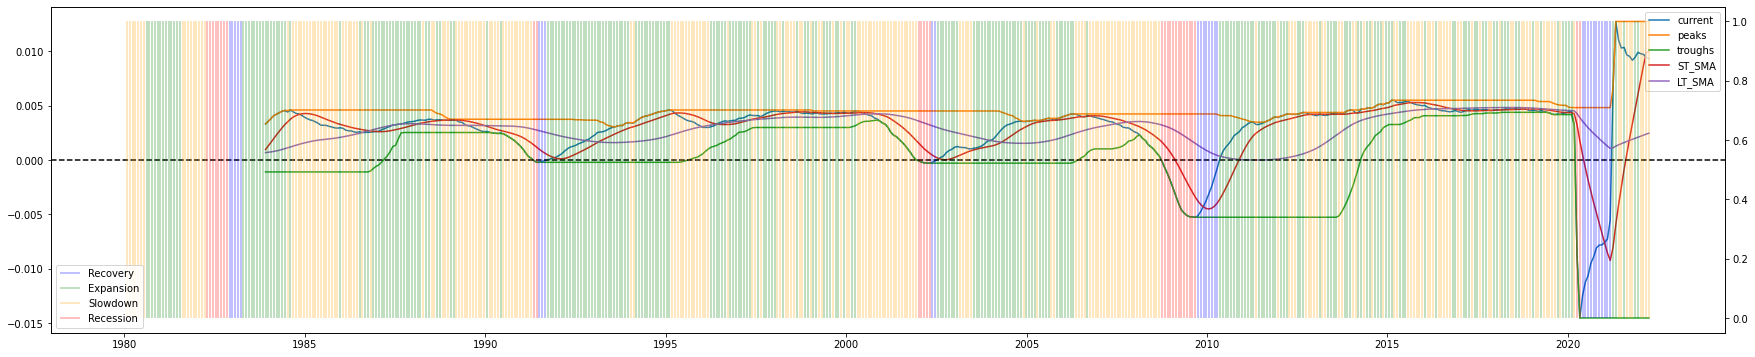

In [51]:
fig, ax1 = plt.subplots( figsize=(30,6) )
#plt.plot(cli_df_USA['Value'])
ax1.plot(business_cycle['signal'])

ax1.plot(business_cycle['peaks'])
ax1.plot(business_cycle['troughs'])
ax1.plot(business_cycle['ST_SMA'])
ax1.plot(business_cycle['LT_SMA'])
ax1.axhline(y = 0, color = 'black', linestyle = '--')
ax1.legend(['current','peaks','troughs','ST_SMA','LT_SMA'],loc=1)
#plt.legend(['current','ST_SMA','LT_SMA'],loc=1)

ax2 = ax1.twinx()

trans = mtransforms.blended_transform_factory(ax2.transData, ax2.transAxes)

ax2.vlines((recovery == 1).index[(recovery == 1).values],color='blue', alpha=0.33, ymin=0, ymax=1, colors=None, linestyles='solid',label='Recovery')
ax2.vlines((expansion == 1).index[(expansion == 1).values],color='green', alpha=0.33, ymin=0, ymax=1, colors=None, linestyles='solid',label='Expansion')
ax2.vlines((slowdown == 1).index[(slowdown == 1).values],color='orange', alpha=0.33, ymin=0, ymax=1, colors=None, linestyles='solid',label='Slowdown')
ax2.vlines((recession == 1).index[(recession == 1).values],color='red', alpha=0.33, ymin=0, ymax=1, colors=None, linestyles='solid',label='Recession')

ax2.legend(['Recovery','Expansion','Slowdown','Recession'],loc=3)
plt.show()

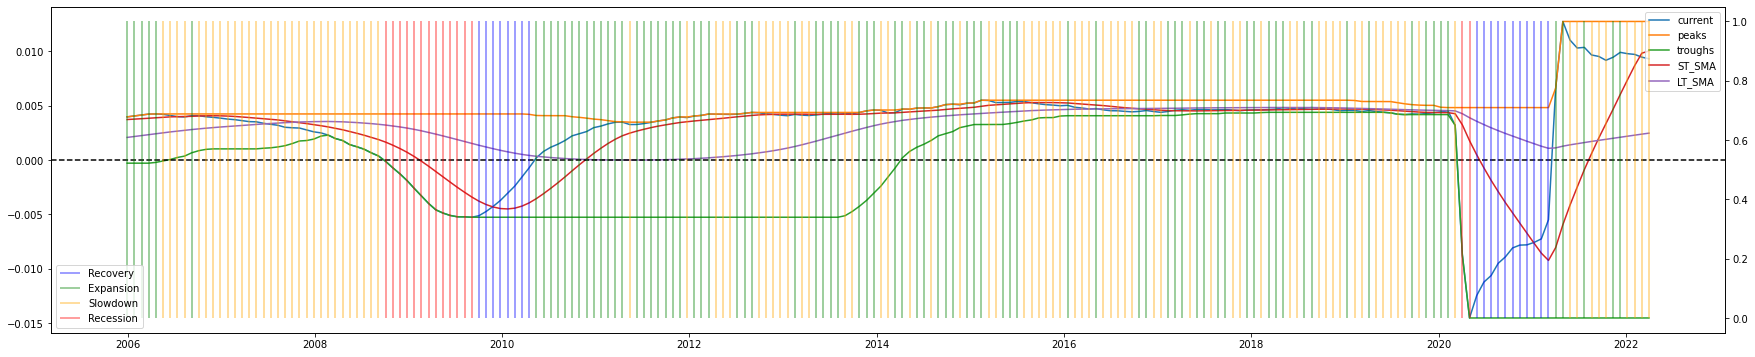

In [52]:
fig, ax1 = plt.subplots( figsize=(30,6) )
#plt.plot(cli_df_USA['Value'])
ax1.plot(business_cycle['signal'].reindex(combined_indexes_sectors_return_pvt_df.index))

ax1.plot(business_cycle['peaks'].reindex(combined_indexes_sectors_return_pvt_df.index))
ax1.plot(business_cycle['troughs'].reindex(combined_indexes_sectors_return_pvt_df.index))
ax1.plot(business_cycle['ST_SMA'].reindex(combined_indexes_sectors_return_pvt_df.index))
ax1.plot(business_cycle['LT_SMA'].reindex(combined_indexes_sectors_return_pvt_df.index))
ax1.axhline(y = 0, color = 'black', linestyle = '--')
ax1.legend(['current','peaks','troughs','ST_SMA','LT_SMA'],loc=1)
#plt.legend(['current','ST_SMA','LT_SMA'],loc=1)

ax2 = ax1.twinx()

trans = mtransforms.blended_transform_factory(ax2.transData, ax2.transAxes)

"""
ax2.fill_between(business_cycle.index, 0, 1, where=Recovery['USPHCI'].reindex(business_cycle.index) == 1,facecolor='blue', alpha=0.5, transform=trans)
ax2.fill_between(business_cycle.index, 0, 1, where=Expansion['USPHCI'].reindex(business_cycle.index) == 1,facecolor='orange', alpha=0.5, transform=trans)
ax2.fill_between(business_cycle.index, 0, 1, where=Slowdown['USPHCI'].reindex(business_cycle.index) == 1,facecolor='green', alpha=0.5, transform=trans)
ax2.fill_between(business_cycle.index, 0, 1, where=Recession['USPHCI'].reindex(business_cycle.index) == 1,facecolor='red', alpha=0.5, transform=trans)
"""   
 
ax2.vlines((recovery.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).index[(recovery.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).values],color='blue', alpha=0.5, ymin=0, ymax=1, colors=None, linestyles='solid',label='Recovery')
ax2.vlines((expansion.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).index[(expansion.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).values],color='green', alpha=0.5, ymin=0, ymax=1, colors=None, linestyles='solid',label='Expansion')
ax2.vlines((slowdown.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).index[(slowdown.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).values],color='orange', alpha=0.5, ymin=0, ymax=1, colors=None, linestyles='solid',label='Slowdown')
ax2.vlines((recession.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).index[(recession.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).values],color='red', alpha=0.5, ymin=0, ymax=1, colors=None, linestyles='solid',label='Recession')

ax2.legend(['Recovery','Expansion','Slowdown','Recession'],loc=3)
plt.show()

In [26]:
np.sum(business_cycle.iloc[:,-4:])

recovery      24
expansion    235
slowdown     220
recession     22
dtype: int64

In [27]:
np.sum(np.sum(business_cycle.iloc[:,-4:]))

501

In [28]:
#Slowdown = (ST_SMA < peak)
#np.sum(Slowdown)

In [29]:
"""
Slowdown = (ST_SMA.pct_change()<0) * (cli_df_USA['Value']<peaks)# (ST_SMA<LT_SMA)
Slowdown = (signal.pct_change()<0) * (signal<peak)# (ST_SMA<LT_SMA)
np.sum(Slowdown)
"""

"\nSlowdown = (ST_SMA.pct_change()<0) * (cli_df_USA['Value']<peaks)# (ST_SMA<LT_SMA)\nSlowdown = (signal.pct_change()<0) * (signal<peak)# (ST_SMA<LT_SMA)\nnp.sum(Slowdown)\n"

In [30]:
#plt.plot(prior_recession * Slowdown['USPHCI'])

In [31]:
"""
print(np.sum(Slowdown))

while (np.sum(prior_recession * Slowdown['USPHCI'])>0):
     
    positions = prior_recession * Slowdown['USPHCI']
    
    #print(np.where(positions))
    
    Recession.iloc[positions] = True
    Slowdown.iloc[positions] = False

    prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]
    Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<peak)
    #positions = np.intersect1d(prior_recession,Slowdown)
    #Recession.iloc[positions] = True
    #Slowdown.iloc[positions] = False
    #prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]
    #Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<peak)
    
    
    
    #print(np.sum(Slowdown))

    
"""

"\nprint(np.sum(Slowdown))\n\nwhile (np.sum(prior_recession * Slowdown['USPHCI'])>0):\n     \n    positions = prior_recession * Slowdown['USPHCI']\n    \n    #print(np.where(positions))\n    \n    Recession.iloc[positions] = True\n    Slowdown.iloc[positions] = False\n\n    prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]\n    Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<peak)\n    #positions = np.intersect1d(prior_recession,Slowdown)\n    #Recession.iloc[positions] = True\n    #Slowdown.iloc[positions] = False\n    #prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]\n    #Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<peak)\n    \n    \n    \n    #print(np.sum(Slowdown))\n\n    \n"

In [32]:
"""
list1 = [-1, -1, 1, 1, 1, -1, 1]
count_dups = [sum(1 for _ in group) for _, group in groupby(list1)]
print(count_dups)
"""

#business_cycle = pd.concat([signal,Recovery,Expansion,Slowdown,Recession],axis=1)
#business_cycle.columns=['Leading','Recovery','Expansion','Slowdown','Recession']
#business_cycle = business_cycle.reindex(peak.dropna().index).dropna()

"""
for c_ in range(1,len(business_cycle.iloc[:,1:].columns)+1):
    c = business_cycle.iloc[:,1:].columns[c_-1]
    business_cycle[c][business_cycle[c]==True] = c_
    business_cycle[c][business_cycle[c]==False] = np.nan

repeats = business_cycle.iloc[:,1:].bfill(axis=1).iloc[:, 0]

#list1 = [-1, -1, 1, 1, 1, -1, 1]
count_dups = [sum(1 for _ in group) for _, group in groupby(repeats)]
print(count_dups)

"""

'\nfor c_ in range(1,len(business_cycle.iloc[:,1:].columns)+1):\n    c = business_cycle.iloc[:,1:].columns[c_-1]\n    business_cycle[c][business_cycle[c]==True] = c_\n    business_cycle[c][business_cycle[c]==False] = np.nan\n\nrepeats = business_cycle.iloc[:,1:].bfill(axis=1).iloc[:, 0]\n\n#list1 = [-1, -1, 1, 1, 1, -1, 1]\ncount_dups = [sum(1 for _ in group) for _, group in groupby(repeats)]\nprint(count_dups)\n\n'

In [33]:
"""
iter = 0
values = []
iterator=0
for c_ in range(0,len(count_dups)):
    c = count_dups[c_]
    #values.append()
    #c_* len(iterator)
    iterator = iterator + c - 1
    values.append(repeats[c_+iterator])
    
values_df = pd.DataFrame(values)

values_df[(values_df==3)*(values_df.shift(1)==4)] = 4
"""

'\niter = 0\nvalues = []\niterator=0\nfor c_ in range(0,len(count_dups)):\n    c = count_dups[c_]\n    #values.append()\n    #c_* len(iterator)\n    iterator = iterator + c - 1\n    values.append(repeats[c_+iterator])\n    \nvalues_df = pd.DataFrame(values)\n\nvalues_df[(values_df==3)*(values_df.shift(1)==4)] = 4\n'

In [34]:
nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start, end_date=end)

In [35]:
"""
fig, ax1 = plt.subplots( figsize=(30,4) )
plt.plot(recession.reindex(combined_indexes_sectors_return_pvt_df.index))
#plt.fill_between(recession.reindex(combined_indexes_sectors_return_pvt_df.index), 0, 1, where=recession.reindex(combined_indexes_sectors_return_pvt_df.index),
    #facecolor='blue', alpha=0.5, transform=trans)
#plt.legend(loc=1)
#plt.legend(loc=3)
plt.show()
"""

"\nfig, ax1 = plt.subplots( figsize=(30,4) )\nplt.plot(recession.reindex(combined_indexes_sectors_return_pvt_df.index))\n#plt.fill_between(recession.reindex(combined_indexes_sectors_return_pvt_df.index), 0, 1, where=recession.reindex(combined_indexes_sectors_return_pvt_df.index),\n    #facecolor='blue', alpha=0.5, transform=trans)\n#plt.legend(loc=1)\n#plt.legend(loc=3)\nplt.show()\n"

In [36]:
business_cycles_sectors_indexes = pd.concat([business_cycle,combined_indexes_sectors_return_pvt_df],axis=1).dropna()

In [50]:
#business_cycles_sectors_indexes[business_cycles_sectors_indexes['recession']==True]

In [ ]:
#plt.plot(business_cycles_sectors_indexes[business_cycles_sectors_indexes[bc]==True]['SPY'])

In [100]:
pd.DataFrame(business_cycles_sectors_indexes.mean(axis=0)).T.loc[0][14:]

VOX    0.007368
VCR    0.007462
VDC    0.008355
VDE    0.011600
VFH    0.008186
VHT    0.008996
VIS    0.005607
VGT    0.006024
VAW    0.007959
VNQ    0.010248
VPU    0.006281
Name: 0, dtype: float64

In [102]:
subset[sectors]#-pd.DataFrame(business_cycles_sectors_indexes.mean(axis=0)).T.loc[0][14:]

,VOX,VCR,VDC,VDE,VFH,VHT,VIS,VGT,VAW,VNQ,VPU
2008-10-03,-0.068826,-0.012961,-0.101203,-0.111345,-0.088527,-0.050431,0.001173,-0.090239,-0.010404,-0.041220,-0.081333
2008-10-31,-0.178405,-0.287705,-0.302198,-0.209774,-0.245124,-0.158095,-0.234471,-0.271484,-0.144397,-0.267902,-0.229334
2008-11-28,0.020145,-0.216537,-0.108137,-0.102904,-0.079116,-0.048209,-0.155989,-0.013350,-0.027506,-0.110635,-0.024889
2008-12-26,-0.002443,0.008638,-0.018396,-0.012080,-0.004980,-0.006027,-0.034463,-0.045699,-0.011691,0.042484,0.048067
2009-01-23,0.023085,0.005841,0.023956,0.020888,0.014871,0.042434,-0.063930,0.031813,0.009780,0.023748,0.012459
2009-02-20,-0.007496,-0.113564,-0.043746,0.004462,-0.097627,0.017761,-0.161160,-0.019321,-0.050058,-0.074740,-0.025518
2009-03-20,-0.154057,-0.184415,-0.105229,-0.070042,-0.173770,-0.117011,-0.161251,-0.132190,-0.078030,-0.087528,-0.061748
2009-04-17,0.071042,0.139231,0.198151,0.156081,0.166424,0.044121,0.264180,0.112870,0.075265,0.198977,0.143373
2009-05-15,0.018274,0.169006,0.101352,0.069543,0.123574,0.018628,0.134678,0.068953,0.030340,0.111253,0.031053
2009-06-12,0.020384,0.044007,0.072753,0.049191,0.044205,0.041247,0.057120,0.082976,0.055253,0.024689,0.025984


In [103]:
subset[sectors]-pd.DataFrame(business_cycles_sectors_indexes.mean(axis=0)).T.loc[0][14:]

,VOX,VCR,VDC,VDE,VFH,VHT,VIS,VGT,VAW,VNQ,VPU
2008-10-03,-0.076194,-0.020423,-0.109558,-0.122945,-0.096713,-0.059428,-0.004434,-0.096263,-0.018363,-0.051468,-0.087614
2008-10-31,-0.185773,-0.295166,-0.310553,-0.221374,-0.253310,-0.167092,-0.240078,-0.277507,-0.152356,-0.278150,-0.235615
2008-11-28,0.012776,-0.223999,-0.116492,-0.114504,-0.087302,-0.057205,-0.161596,-0.019374,-0.035465,-0.120883,-0.031170
2008-12-26,-0.009811,0.001176,-0.026751,-0.023680,-0.013166,-0.015024,-0.040070,-0.051723,-0.019650,0.032237,0.041786
2009-01-23,0.015717,-0.001621,0.015601,0.009287,0.006685,0.033438,-0.069538,0.025789,0.001820,0.013500,0.006178
2009-02-20,-0.014864,-0.121026,-0.052101,-0.007138,-0.105813,0.008765,-0.166767,-0.025345,-0.058017,-0.084988,-0.031798
2009-03-20,-0.161425,-0.191877,-0.113584,-0.081642,-0.181956,-0.126008,-0.166859,-0.138214,-0.085990,-0.097775,-0.068029
2009-04-17,0.063673,0.131769,0.189796,0.144480,0.158237,0.035124,0.258572,0.106847,0.067305,0.188729,0.137092
2009-05-15,0.010906,0.161544,0.092997,0.057943,0.115387,0.009632,0.129070,0.062929,0.022381,0.101005,0.024773
2009-06-12,0.013015,0.036545,0.064398,0.037591,0.036019,0.032250,0.051513,0.076952,0.047293,0.014441,0.019703


In [114]:
indexes

['SPTM', 'SPY', 'SLY', 'MDYG', 'DIA']

,SPTM,SPY,SLY,MDYG,DIA
2009-10-02,0.023062,0.058454,0.052360,0.030725,0.033924
2009-10-30,0.015383,0.014363,0.001192,0.013603,0.011421
2009-11-27,0.027549,-0.015409,-0.034513,0.007765,0.003221
2009-12-25,0.014778,0.026252,0.028071,0.012867,0.013945
2010-01-22,0.008938,0.049110,0.048027,0.017536,0.020989
2010-02-19,-0.045912,-0.059653,-0.048814,-0.050590,-0.048628
2010-03-19,0.030092,0.062657,0.068467,0.037128,0.043376
2010-04-16,0.033213,0.044224,0.050327,0.037674,0.039133
2020-05-29,0.025358,0.082088,0.051613,0.039541,0.041214
2020-06-26,0.069204,0.070989,0.096652,0.056619,0.059444


VOX    0.007368
VCR    0.007462
VDC    0.008355
VDE    0.011600
VFH    0.008186
VHT    0.008996
VIS    0.005607
VGT    0.006024
VAW    0.007959
VNQ    0.010248
VPU    0.006281
Name: 0, dtype: float64

In [121]:
i_m.columns

Index(['SP1500', 'SP500', 'SP600', 'SP400', 'DOW'], dtype='object')

In [133]:
(i_s/np.sqrt(n)).T

,0
SPTM,0.005752
SPY,0.008377
SLY,0.010730
MDYG,0.005599
DIA,0.005802


,SPTM,SPY,SLY,MDYG,DIA
2009-10-02 00:00:00,NaN,NaN,NaN,NaN,NaN
2009-10-30 00:00:00,NaN,NaN,NaN,NaN,NaN
2009-11-27 00:00:00,NaN,NaN,NaN,NaN,NaN
2009-12-25 00:00:00,NaN,NaN,NaN,NaN,NaN
2010-01-22 00:00:00,NaN,NaN,NaN,NaN,NaN
2010-02-19 00:00:00,NaN,NaN,NaN,NaN,NaN
2010-03-19 00:00:00,NaN,NaN,NaN,NaN,NaN
2010-04-16 00:00:00,NaN,NaN,NaN,NaN,NaN
2020-05-29 00:00:00,NaN,NaN,NaN,NaN,NaN
2020-06-26 00:00:00,NaN,NaN,NaN,NaN,NaN


,SPTM,SPY,SLY,MDYG,DIA
0,0.007924,0.008542,0.008813,0.00818,0.008228


In [179]:
s_m_subset_mean

,VOX,VCR,VDC,VDE,VFH,VHT,VIS,VGT,VAW,VNQ,VPU
0,0.007819,0.027972,0.034829,0.036559,0.037216,0.021493,0.031788,0.033414,0.017077,0.047275,0.033924


In [165]:
sectors_across_cycles.mean(axis=0)

SPTM   -0.025496
SPY    -0.024676
SLY    -0.030076
MDYG   -0.025972
DIA    -0.026468
DIA    -0.026468
dtype: float64

In [181]:
for bc in ['recovery','expansion','slowdown','recession']:    
    subset = business_cycles_sectors_indexes[business_cycles_sectors_indexes[bc]==True]
    #print(subset)
    n = len(subset)
    print(bc,n)    
    #i_m_subset_mean = pd.DataFrame(subset[indexes].mean(axis=0))#T#-business_cycles_sectors_indexes[business_cycles_sectors_indexes[bc]==True]['DIA'].mean()
    #i_m = pd.DataFrame(business_cycles_sectors_indexes.mean().loc[i_m_subset_mean.index]).T
    i_m = pd.DataFrame(business_cycles_sectors_indexes.mean().loc[i_m_subset_mean.index]).T
    
    """
    indexes_across_cycles = pd.DataFrame()
    for ei in indexes:
        indexes_across_cycles = pd.concat([indexes_across_cycles,subset[ei]-pd.DataFrame(business_cycles_sectors_indexes.mean(axis=0)).T.loc[0][ei]],axis=1)
    """ 
    
    #i_m = subset[indexes]-pd.DataFrame(business_cycles_sectors_indexes.mean(axis=0)).T.loc[0][9:14]
    #i_m_over_index = pd.DataFrame(subset[indexes].mean(axis=0)).T-business_cycles_sectors_indexes[business_cycles_sectors_indexes[bc]==True]['DIA'].mean()
    i_s = pd.DataFrame(subset[indexes].std(axis=0)).T
    
    #i_z = i_m/i_s
    
    #testing if aggregated index/cycle performance is significantly different from 0
    
    i_t = (i_m)/(i_s/np.sqrt(n))
    i_m.columns = [dict_indexes[i] for i in i_m.columns]
    p_values = pd.DataFrame(t.cdf(i_t, df=n-2),index=[bc],columns=i_m.columns)
    st.norm.cdf(1.64)
    
    df0 = i_m.T.sort_values(by=0,ascending=False)
    #display(i_m.T.sort_values(by=0,ascending=False))
    
    df1 = p_values.T.sort_values(by=p_values.index[0])
    #display(p_values.T.sort_values(by=p_values.index[0]))#.style.applymap(highlight_cells, threshold=.05)
    
    s_m = pd.DataFrame(subset[sectors].mean(axis=0)).T
    #s_m_subset_mean = pd.DataFrame(subset[sectors].mean(axis=0))##-business_cycles_sectors_indexes[business_cycles_sectors_indexes[bc]==True]['DIA'].mean()
    #s_m = pd.DataFrame(business_cycles_sectors_indexes.mean().loc[s_m_subset_mean.index]).T
    
    sectors_across_cycles = pd.DataFrame()
    for es in indexes:
        sectors_across_cycles = pd.concat([sector_across_cycles,subset[es]-pd.DataFrame(business_cycles_sectors_indexes.mean(axis=0)).T.loc[0][es]],axis=1)
    
    #s_m = pd.DataFrame(subset[sectors].mean(axis=0)).T-pd.DataFrame(business_cycles_sectors_indexes.mean(axis=0)).T.loc[0][14:]
    #s_m_over_index = pd.DataFrame(subset[sectors].mean(axis=0)).T-business_cycles_sectors_indexes[business_cycles_sectors_indexes[bc]==True]['DIA'].mean()
    #sector_over_cycle = s_m_over_sector = pd.DataFrame(subset[sectors].mean(axis=0)).T-business_cycles_sectors_indexes[business_cycles_sectors_indexes[bc]==True]['DIA'].mean()
    
    s_s = pd.DataFrame(subset[sectors].std(axis=0)).T
    #s_z = s_m/s_s
    
    #A p score < .05 would indicate that the return (represented as a t-score) is significantly different than 0.
    #testing if aggregated sector/cycle performance is significantly different from 0
    s_t = (s_m)/(s_s/np.sqrt(n))
    s_m.columns = [dict_sectors_reverse[s] for s in s_m.columns]
    p_values = pd.DataFrame(t.cdf(s_t, df=n-2),index=[bc],columns=s_m.columns)
    s_m = s_m.T.sort_values(by=0,ascending=False).T
    
    df2 = s_m.T.sort_values(by=0,ascending=False)
    #display(s_m.T.sort_values(by=0,ascending=False))
    #print(pd.DataFrame(t.cdf(s_t, df=n-2),index=[bc],columns=sectors))
     
    df3 = p_values.T.sort_values(by=p_values.index[0])
    #df3 = p_values.T.sort_values(by=p_values.index[0]).style.applymap(highlight_cells, threshold=.5)
    #display(p_values.T.sort_values(by=p_values.index[0]).style.applymap(highlight_cells, threshold=.5))
    
    display_side_by_side([df0, df1, df2, df3], ['Index Return', 'Index p-values', 'Sector Return', 'Sector p-values'])
    #print(s_.T.sort_values(by=0,ascending=False))
    

recovery 19


,0
SP600,0.008813
SP500,0.008542
DOW,0.008228
SP400,0.008180
SP1500,0.007924
,recovery
SP600,0.788581
SP500,0.838936
SP1500,0.906910
DOW,0.912891


expansion 83


,0
SP600,0.008813
SP500,0.008542
DOW,0.008228
SP400,0.008180
SP1500,0.007924
,expansion
SP600,0.990550
SP500,0.992806
DOW,0.997059
SP400,0.997395


slowdown 96


,0
SP600,0.008813
SP500,0.008542
DOW,0.008228
SP400,0.008180
SP1500,0.007924
,slowdown
SP600,0.992875
SP500,0.994568
SP1500,0.996998
DOW,0.998152


recession 15


,0
SP600,0.008813
SP500,0.008542
DOW,0.008228
SP400,0.008180
SP1500,0.007924
,recession
SP600,0.597111
SP500,0.599228
DOW,0.618447
SP400,0.618919


In [39]:
np.sum(business_cycles_sectors_indexes.reindex(business_cycles_sectors_indexes.index).iloc[:,5:9].sum(axis=0))

213